In [1]:
import math, random, pickle, os, copy, itertools, sys
import torch, scipy.io
import numpy as np
import pandas as pd
from numpy import random
import matplotlib.pyplot as plt

sys.path.append(os.path.dirname(os.getcwd())) 

from PVDataset import *

random_seed = 3
random.seed(random_seed)
np.random.seed(random_seed)
random_state = np.random.RandomState(random_seed)


# Generate data for multiple households
* vary the tilt of the installation and the azimuthal orientation
* same coordinates and altitude of central Lausanne

In [2]:
# geographical characteristics of the location
latitude=46.520
longitude=6.632
name='Lausanne'
altitude=496
timezone='Etc/GMT-1'

In [3]:
generate_data = True

if generate_data:

    a_file = open("saved_results/hours.pkl", "rb")
    hours = pickle.load(a_file)

    a_file = open("saved_results/months.pkl", "rb")
    months = pickle.load(a_file)

    a_file = open("saved_results/Lags_FS.pkl", "rb")
    Lags_FS = pickle.load(a_file)

    lags=Lags_FS['best_num_adjr2']

    print('INFO: generating data for months', *months, 'hours', *hours, '.')
    print('using lags :', *lags)


    # dataset info: tilt and azimuth distributions
    mean_tilt  = latitude
    mean_azimuth = 180
    sigma_tilt = 15
    mean_az  = 180
    sigma_az = 45

    # task distribution    
    mu_t = [mean_tilt, mean_azimuth]
    cov_t = np.diag([sigma_tilt**2, sigma_az**2])

    # FL info
    num_clients = 25

    # Configuration w.r.t. data

    generate_normalized_data = True

    # generate data from each mode
    task_environment = PVDataset(mu_t=mu_t, cov_t=cov_t, lags=lags,
                                 latitude=latitude, longitude=longitude, altitude=altitude,
                                 random_state=random_state)


    print('[INFO] generating data for {:2.0f} clients'.format(num_clients))
    clients_data, clients_train_ts, clients_valid_ts = task_environment.generate_clients_data(num_clients=num_clients, 
                                                          months=months, hours=hours)
    if 'target' in task_environment.feature_names:
        task_environment.feature_names.remove('target')

    clients_train_data = [] # training data of all clients
    clients_valid_data = [] # validation data of all clients

    for n in np.arange(num_clients):
        x_obs, y_obs, x_tru, y_tru = clients_data[n]

        # normalize
        if generate_normalized_data:
            # compute mean and std from train
            x_mean, y_mean = np.mean(x_obs, axis=0), np.mean(y_obs, axis=0)
            x_std, y_std = np.std(x_obs, axis=0) + 1e-8, np.std(y_obs, axis=0) + 1e-8
            # normalize
            clients_train_data.append(((x_obs-x_mean)/x_std, (y_obs-y_mean)/y_std))
            clients_valid_data.append(((x_tru-x_mean)/x_std, (y_tru-y_mean)/y_std))
            clients_train_ts[n]['p_mp'] = (list(clients_train_ts[n]['p_mp'])-y_mean)/y_std
            clients_valid_ts[n]['p_mp'] = (list(clients_valid_ts[n]['p_mp'])-y_mean)/y_std
            clients_data[n] = (clients_train_data[n][0], clients_train_data[n][1],
                               clients_valid_data[n][0],  clients_valid_data[n][1])
        else:
            clients_train_data.append((x_obs, y_obs))
            clients_valid_data.append((x_tru, y_tru))

    # Save
    env_dict = {'hours':hours, 'months':months, 'mu_t':mu_t,
                'cov_t':cov_t, 'num_clients':num_clients, 
                'clients_train_data':clients_train_data, 
                'clients_valid_data':clients_valid_data,
                'clients_train_ts':clients_train_ts, 
                'clients_valid_ts':clients_valid_ts,
                'generate_normalized_data': generate_normalized_data}
    # dump env dict
    file1 = open('saved_results/env_dict', 'wb')
    pickle.dump(env_dict, file1)
    # dump clients data
    file2 = open('saved_results/clients_data', 'wb')
    pickle.dump(clients_data, file2)
    # save as .mat
    scipy.io.savemat('saved_results/clients_data.mat', {'clients_data': clients_data})
    print('[INFO] saved data for {:2.0f} clients'.format(num_clients))
else:
    file1 = open('saved_results/env_dict', 'rb')
    env_dict = pickle.load(file1)
    for key, value in env_dict.items(): #TODO: not sure if works for lists
        locals()[key]=value
    file2 = open('saved_results/clients_data', 'rb')
    clients_data = pickle.load(file2)
    num_clients = len(clients_data)
    print('[INFO] loaded data for {:2.0f} clients'.format(num_clients))
# close the file
file1.close()
file2.close()


INFO: generating data for months 3 4 hours 11 12 13 14 15 .
using lags : 1 2 8 16 17 18 19 20 21 22 23
[INFO] generating data for 25 clients
[INFO] saved data for 25 clients


In [4]:
num_features = len(task_environment.feature_names)
num_train_samples = [None]*num_clients
num_valid_samples  = [None]*num_clients

for client_num in np.arange(num_clients):
    # train
    (x, y) = clients_train_data[client_num]
    assert x.shape[1] == len(task_environment.feature_names)
    assert x.shape[0] == len(y)
    num_train_samples[client_num] = x.shape[0]
    # valid
    (x, y) = clients_valid_data[client_num]
    assert x.shape[1] == len(task_environment.feature_names)
    assert x.shape[0] == len(y)
    num_valid_samples[client_num] = x.shape[0]
    
print('[INFO] number of modes = {:2.0f}, number of clients = {:2.0f}'.format(len(mu_t), num_clients))
print('[INFO] clients training samples = ', *num_train_samples)
print('[INFO] clients valid samples = ', *num_valid_samples)
print('[INFO] number of features = {:2.0f}, features:'.format(len(task_environment.feature_names)), *task_environment.feature_names)        



[INFO] number of modes =  2, number of clients = 25
[INFO] clients training samples =  305 305 305 305 305 305 305 305 305 305 305 305 305 305 305 305 305 305 305 305 305 305 305 305 305
[INFO] clients valid samples =  303 303 303 303 303 303 303 303 303 303 303 303 303 303 303 303 303 303 303 303 303 303 303 303 303
[INFO] number of features = 14, features: H_sun T2m WS10m dayofy_y lag 1 lag 2 lag 8 lag 17 lag 18 lag 19 lag 20 lag 21 lag 22 lag 23


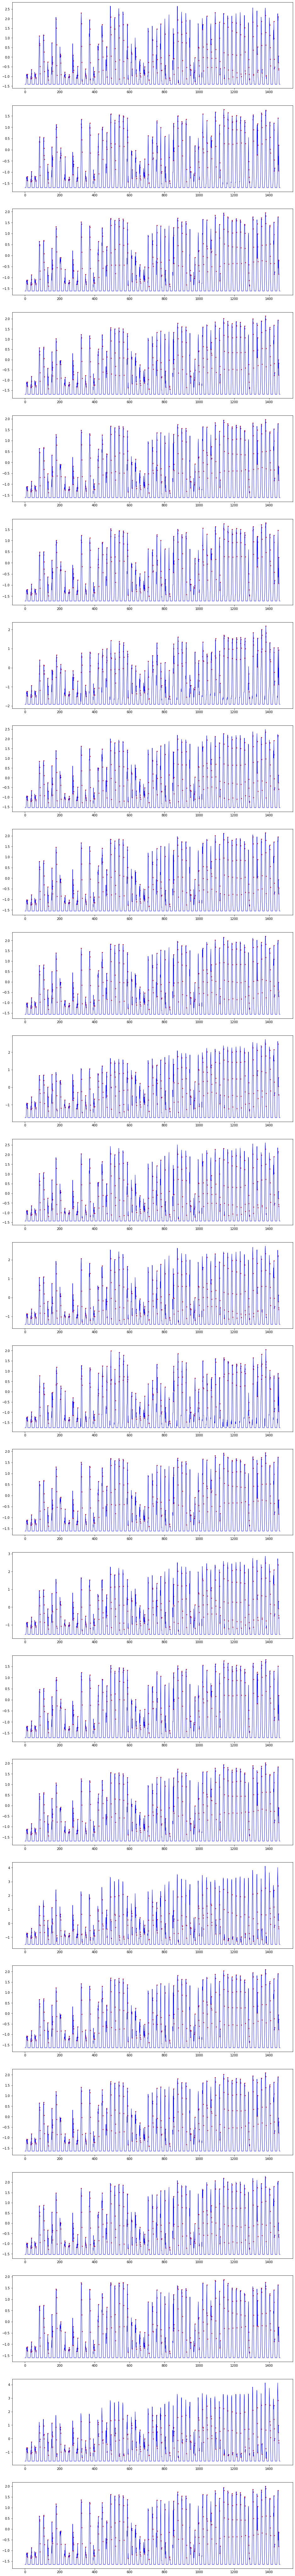

In [5]:
def visualize_ts(client_ts, pred_mean=None, pred_std=None, title=None,
                 selected_months=None, hours = None, figsize=(16, 6)):

    '''
    visulaize predictions for one client
    '''
    # check predictions provided for all clients
    #if (pred_mean is not None) or (pred_std is not None):
    #    assert (pred_mean is not None) and (pred_std is not None)
    #    assert len(pred_mean) == len(pred_std)
   
    fig, ax = plt.subplots(1,1, figsize=figsize)

    if selected_months is not None:
        client_ts = client_ts.loc[client_ts['month'].isin(selected_months), :]
    client_ts = client_ts.reset_index()
    ax.plot(list(client_ts.p_mp), c='b', lw=1, label='true')
    # TODO label with hours
    ax.set_xlabel('time (h)')
    ax.set_xlabel('generated power (kWh/h)')
    if not title is None:
        ax.set_title(title) 
    # plot predictions
    if pred_mean is not None and hours is not None:
        # get indexes of the ts that correspond to predicted steps
        ind = client_ts[client_ts['hour_day'].isin(hours)].index.tolist()
        ind = ind[0:pred_mean.shape[0]] # TODO: this is a bug in test_ts. ind and pred means must be the same size
        #ind = [i-1 for i in ind] 
        ax.scatter(ind, pred_mean, color='r', s=5, label='prediction')
        if pred_std is not None:
            lb = list(client_ts.p_mp)
            ub = list(client_ts.p_mp)
            for i in np.arange(len(ind)): 
                lb[ind[i]] = pred_mean[i] - 1.645 * pred_std[i]
                ub[ind[i]] = pred_mean[i] + 1.645 * pred_std[i]
            ax.fill_between(np.arange(len(lb)), lb, ub, label = 'confidence', color='red',
             alpha=0.5)
    

for client_num in np.arange(num_clients):
    title = 'Predictions on training data for client {:2.0f}'.format(client_num)
    _, predictions = clients_train_data[client_num] # assume an ideal model with zero error, in practice, this must be the output of your model on clients_train_data[client_num][0] 
    visualize_ts(clients_ts=clients_train_ts[client_num], pred_mean=predictions, selected_months=months, hours=hours, title = title)